# earthaccess a NASA Earthdata API Client 🌍 in Python

## Overview

**TL;DR**:  *earthaccess* is uses NASA APIs to search, preview and access NASA datasets on-prem and in the cloud with 4 lines of Python.

There are many ways to access NASA datasets, we can use the NASA's Earthdata search portal. We can use DAAC specific websites or tools.
We could even use data.gov! These web portals are great but... they are not designed for programmatic access and reproducible workflows. 
This is extremely important in the age of the cloud and reproducible open science. In this context, **earthaccess** aims to be a simple 
library that can deal with the important parts of the metadata so we can access or download data without having to worry if a given dataset is on-prem or in the cloud.

The core function of auth is to deal with cloud credentials and remote file sessions (fsspec or requests).
essentially, anything that requires you to log in to Earthdata. Most of this will happen behind-the-scenes for you once you have been authenticated.

In [ ]:
%pip uninstall -y earthaccess
%pip install git+https://github.com/nsidc/earthaccess.git@explore

### NASA EDL and the Auth class

* **Step 1**. We need to open an account with [NASA Eardtada](https://urs.earthdata.nasa.gov/), this credentials will allow us to access NASA datasets.

Once we have our account we can use it with *earthaccess* 

In [1]:
import earthaccess

auth = earthaccess.login()

## Searching for data using a region of interest

In [11]:
path = "bosque_primavera.json"
# path = "bosque_primavera.kml" 
# path = "bosque_primavera.shp"
geom = earthaccess.load_geometry(path)

## Search and Access with earthaccess

earthaccess uses NASA's [search API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) to search for data from the different Distributed Archive Centers, the data can be hosted by the DAACs or in AWS, with earthaccess we don't need to think about this because it will handle the authentication for us. For reproducible workflows we just need to use the dataset (or collection as NASA calls them) `concept_id`. 

The `concept_id` of a collection can be found with *earthaccess* or using NASA Earthdata [search portal](https://search.earthdata.nasa.gov/search).


In [9]:
results = earthaccess.search_data(
    concept_id = ["C2613553260-NSIDC_CPRD", "C2237824918-ORNL_CLOUD", "C1908348134-LPDAAC_ECS", "C2021957657-LPCLOUD", "C2631841556-LPCLOUD"],
    temporal = ("2013", "2023"),
    # unpacking the dict
    **geom
)

Granules found: 1905


In [13]:
m = earthaccess.explore(results, roi=geom)
m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

## Accessing the data with `.download()` and `.open()` 

###  Option 1. I'm not in AWS

### Option 2. I'm in AWS `us-west-2` ☁️ 

#### Analysis in place with S3 direct access

Same API, just a different origin

In [14]:
%%time

results = earthaccess.search_data(
    concept_id = ["C2021957657-LPCLOUD"],
    temporal = ("2013", "2023"),
    # unpacking the dict
    **geom
)

# files = earthaccess.open()

Granules found: 472
CPU times: user 212 ms, sys: 19.1 ms, total: 231 ms
Wall time: 3.62 s


In [26]:
%%time
files = earthaccess.open(results[0:4])

Opening 4 granules, approx size: 0.75 GB


QUEUEING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 591 ms, sys: 63.5 ms, total: 654 ms
Wall time: 7.91 s


In [20]:
import rioxarray

ds = rioxarray.open_rasterio(files[0])
ds

<xarray.DataArray (band: 1, y: 3660, x: 3660)>
[13395600 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6.001e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 2.4e+06 2.4e+06 2.4e+06 ... 2.29e+06 2.29e+06
    spatial_ref  int64 0
Attributes: (12/36)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    ...                        ...
    TIRS_SSM_MODEL:            ACTUAL; ACTUAL
    TIRS_SSM_POSITION_STATUS:  NOMINAL; NOMINAL
    ULX:                       600000
    ULY:                       2400000
    USGS_SOFTWARE:             LPGS_15.3.1c
    _FillValue:                -9999

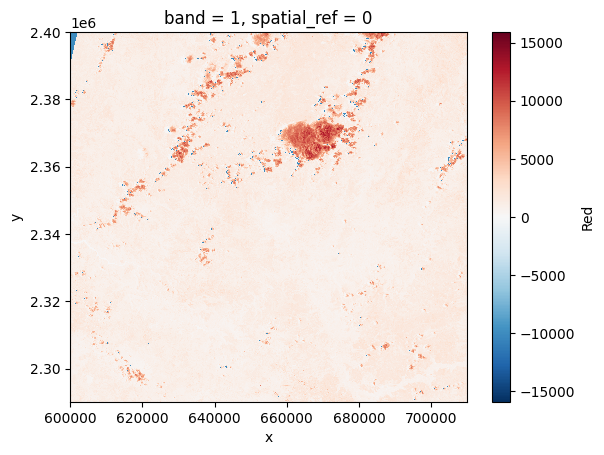

In [21]:
ds.clip()

In [22]:
geometries = [
    {
        'type': 'Polygon',
        'coordinates':[geom["polygon"]]
    }
]
clipped = ds.rio.clip(geometries, drop=True, crs=4326)
clipped

<xarray.DataArray (band: 1, y: 71, x: 570)>
array([[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999],
        ...,
        [-9999,   796,   796, ...,  1016,   792, -9999],
        [  719,   794,   815, ...,   861,   760,   942],
        [  617,   710,   785, ...,   798,   842,  1165]]], dtype=int16)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.404e+05 6.405e+05 ... 6.575e+05 6.575e+05
  * y            (y) float64 2.292e+06 2.292e+06 2.292e+06 ... 2.29e+06 2.29e+06
    spatial_ref  int64 0
Attributes: (12/36)
    ACCODE:                    Lasrc; Lasrc
    add_offset:                0.0
    AREA_OR_POINT:             Area
    arop_ave_xshift(meters):   0, 0
    arop_ave_yshift(meters):   0, 0
    arop_ncp:                  0, 0
    ...                        ...
    TIRS_SSM_MODEL:            ACTUAL; ACTUAL
    TIRS_SSM_POSITION_STATUS:  NOMINAL; NOMINAL
    ULX:                       600000
    ULY:                       2400000
    USGS_SOFTWARE:             LPGS_15.3.1c
    _FillValue:                -9999

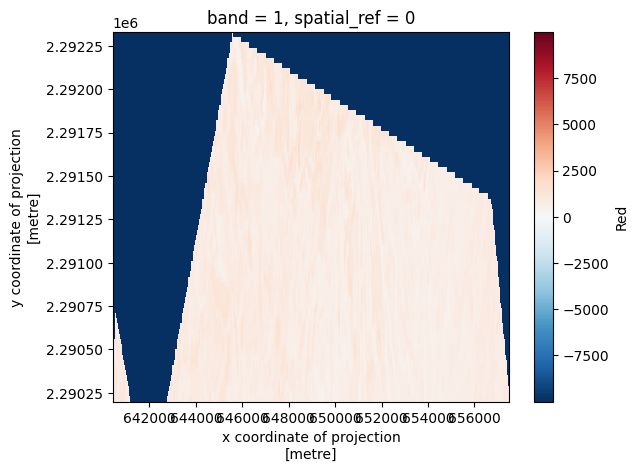

In [25]:
clipped.plot()

In [ ]:

clipped.hvplot(x="x", y="y", crs=xds.rio.estimate_utm_crs()) * map

## Next Step: Subsetting in the Cloud


In [ ]:
%%time
# accessing the data on prem means downloading it if we are in a local environment or "uploading them" if we are in the cloud.
order = earthaccess.subset(results, roi=polygon)

### Related links

**CMR** API documentation: https://cmr.earthaccess.nasa.gov/search/site/docs/search/api.html

**EDL** API documentation: https://urs.earthaccess.nasa.gov/

NASA OpenScapes: https://nasa-openscapes.github.io/earthaccess-cloud-cookbook/

NSIDC: https://nsidc.org